#### Dataset Creation

In [109]:
import random
import torch
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [110]:
import os

datasets_dir = 'datasets'
ecore_json_path = os.path.join(datasets_dir, 'ecore_555/ecore_555.jsonl')
mar_json_path = os.path.join(datasets_dir, 'mar-ecore-github/ecore-github.jsonl')
modelsets_uml_json_path = os.path.join(datasets_dir, 'modelset/uml.jsonl')
modelsets_ecore_json_path = os.path.join(datasets_dir, 'modelset/ecore.jsonl')

In [111]:
from data_loading.data import ModelDataset

config_params = dict(
    timeout = 120,
    min_enr = 1.2,
    min_edges = 10
)
dataset = ModelDataset('ecore_555', reload=False, **config_params)
# dataset = ModelDataset('modelset', reload=False, remove_duplicates=True, **config_params)
# dataset = ModelDataset('mar-ecore-github', reload=True, **config_params)

Loading ecore_555 from pickle
Loaded ecore_555 with 281 graphs
Loaded ecore_555 with 281 graphs
Graphs: 281


In [112]:
from data_loading.graph_dataset import GraphDataset

graph_data_params = dict(
    distance=2,
    reload=False,
    add_negative_train_samples=True,
    neg_sampling_ratio=1,
    use_edge_types=False,
    use_embeddings=True,
    embed_model_name='bert-base-uncased',
    ckpt='results/modelset_ec_ft'
)

graph_dataset = GraphDataset(dataset, **graph_data_params)
# modelset_graph_dataset = GraphDataset(modelset, **graph_data_params)
# mar_graph_dataset = GraphDataset(mar, **graph_data_params)

Creating graphs:   0%|          | 0/281 [00:00<?, ?it/s]

Processing graphs:   0%|          | 0/281 [00:00<?, ?it/s]

In [113]:
# from tokenization.utils import get_special_tokens, get_tokenizer
# from settings import LP_TASK_LINK_PRED
# model_name = 'bert-base-uncased'
# special_tokens = get_special_tokens()
# max_length = 512
# tokenizer = get_tokenizer(model_name, special_tokens, max_length)


# lpd = graph_dataset.get_link_prediction_lm_data(tokenizer=tokenizer, distance=2, task_type=LP_TASK_LINK_PRED)

In [114]:
graph_dataset[0].data.x.size(1)

768

In [115]:
from collections import defaultdict
from typing import List
import pandas as pd
from sklearn.metrics import (
    f1_score, 
    recall_score, 
    roc_auc_score,
    accuracy_score
)
from torch_geometric.nn import aggr

from data_loading.data import LinkPredictionDataLoader
from settings import LP_TASK_EDGE_CLS, LP_TASK_LINK_PRED
from utils import get_device
from itertools import chain
from torch_geometric.data import Data
from tqdm.auto import tqdm

import torch_geometric
import torch.nn as nn

device = get_device()


aggregation_methods = {
    'mean': aggr.MeanAggregation(),
    'sum': aggr.SumAggregation(),
    'max': aggr.MaxAggregation(),
    'mul': aggr.MulAggregation(),
}

supported_conv_models = {
    'GCNConv': False, ## True or False if the model requires num_heads
    'GraphConv': False,
    'GATConv': True,
    'SAGEConv': False,
    'GINConv': False,
    'GatedGraphConv': False,
    'GATv2Conv': True,
}



class GNNModel(torch.nn.Module):
    """
        A general GNN model created using the PyTorch Geometric library
        model_name: the name of the GNN model
        input_dim: the input dimension
        hidden_dim: the hidden dimension
        out_dim: the output dimension

        num_layers: the number of GNN layers
        num_heads: the number of heads in the GNN layer
        residual: whether to use residual connections
        l_norm: whether to use layer normalization
        dropout: the dropout probability
    
    """
    def __init__(
            self, 
            model_name, 
            input_dim, 
            hidden_dim, 
            out_dim, 
            num_layers, 
            num_heads=None, 
            residual=False, 
            l_norm=False, 
            dropout=0.1,
            aggregation='sum',
        ):
        super(GNNModel, self).__init__()

        assert model_name in supported_conv_models, f"Model {model_name} not supported. Choose from {supported_conv_models.keys()}"
        heads_supported = supported_conv_models[model_name]
        assert (num_heads is not None) == heads_supported, f"Model {model_name} requires num_heads to be set to {'an integer' if heads_supported else 'None'}"

        assert aggregation in aggregation_methods, f"Aggregation method {aggregation} not supported. Choose from {aggregation_methods.keys()}"
        aggregation = aggregation_methods[aggregation]

        self.input_dim = input_dim
        self.embed_dim = hidden_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.residual = residual
        self.l_norm = l_norm
        self.dropout = dropout
        

        gnn_model = getattr(torch_geometric.nn, model_name)
        self.conv_layers = nn.ModuleList()
        if num_heads is None:
            input_layer = gnn_model(input_dim, hidden_dim, aggr=aggregation)
        else:
            input_layer = gnn_model(input_dim, hidden_dim, heads=num_heads, aggr=aggregation)
        self.conv_layers.append(input_layer)

        for _ in range(num_layers - 2):
            if num_heads is None:
                self.conv_layers.append(gnn_model(hidden_dim, hidden_dim, aggr=aggregation))
            else:
                self.conv_layers.append(gnn_model(num_heads*hidden_dim, hidden_dim, heads=num_heads, aggr=aggregation))

        self.conv_layers.append(gnn_model(hidden_dim if num_heads is None else num_heads*hidden_dim, out_dim, aggr=aggregation))
            
        self.activation = nn.ReLU()
        self.layer_norm = nn.LayerNorm(hidden_dim if num_heads is None else num_heads*hidden_dim) if l_norm else None
        self.residual = residual
        self.dropout = nn.Dropout(dropout)


    def forward(self, in_feat, edge_index):
        h = in_feat
        h = self.conv_layers[0](h, edge_index)
        h = self.activation(h)
        if self.layer_norm is not None:
            h = self.layer_norm(h)
        h = self.dropout(h)

        for conv in self.conv_layers[1:-1]:
            h = conv(h, edge_index) if not self.residual else conv(h, edge_index) + h
            h = self.activation(h)
            if self.layer_norm is not None:
                h = self.layer_norm(h)
            h = self.dropout(h)
        
        h = self.conv_layers[-1](h, edge_index)
        return h
  

class MLPPredictor(nn.Module):

    """
    An MLP predictor for link prediction

    h_feats: the input dimension
    num_classes: the number of classes
    num_layers: the number of layers in the MLP

    This class concatenates the node embeddings of the two nodes in the edge
    The concatenated embeddings are then passed through an MLP
    """

    def __init__(
            self, 
            h_feats, 
            num_layers=2, 
            num_classes=1,
            dropout=0.3,
            bias=True
        ):
        super().__init__()
        self.layers = nn.ModuleList()
        self.embed_dim = h_feats
        self.num_layers = num_layers
        self.num_classes = num_classes

        in_feats = h_feats * 2
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(in_feats, h_feats, bias=bias))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
            in_feats = h_feats
        
        self.layers.append(nn.Linear(h_feats, num_classes, bias=bias))


    def forward(self, x, edge_index):
        h = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)
        for layer in self.layers:
            h = layer(h)
        
        h = h.squeeze(1)
        return h



class GNNLinkPredictionTrainer:
    """
        Trainer class for GNN Link Prediction
        This class is used to train the GNN model for the link prediction task
        The model is trained to predict the link between two nodes
    """
    def __init__(
            self, 
            model, 
            predictor, 
            dataset: List[Data],
            task_type=LP_TASK_EDGE_CLS,
            lr=1e-3,
            num_epochs=100,
            batch_size=32
        ) -> None:
        self.model = model
        self.predictor = predictor
        self.model.to(device)
        self.predictor.to(device)
        self.task = task_type

        self.dataloader = LinkPredictionDataLoader(
            dataset, 
            batch_size=batch_size, 
            shuffle=False
        )

        self.optimizer = torch.optim.Adam(chain(model.parameters(), predictor.parameters()), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=num_epochs)
        
        self.edge2index = lambda g: torch.stack(list(g.edges())).contiguous()
        self.results = list()
        self.lp_criterion = nn.BCEWithLogitsLoss()
        self.ec_criterion = nn.CrossEntropyLoss()

        print("GNN Trainer initialized.")


    def train(self):
        self.model.train()
        self.predictor.train()

        epoch_loss = 0
        epoch_metrics = defaultdict(float)
        # for i, data in tqdm(enumerate(self.dataloader), desc=f"Training batches", total=len(self.dataloader)):
        for data in self.dataloader:
            self.optimizer.zero_grad()
            self.model.zero_grad()
            self.predictor.zero_grad()
            
            h = self.get_logits(data.x, data.train_pos_edge_label_index)

            if self.task == LP_TASK_EDGE_CLS:
                scores = self.get_prediction_score(data.train_pos_edge_label_index, h)
                labels = data.edge_classes[data.train_edge_idx]
                loss = self.compute_ec_loss(scores, labels)
                metrics = self.compute_ec_metrics(scores.detach(), labels)
            else:
                pos_score = self.get_prediction_score(data.train_pos_edge_label_index, h)
                neg_score = self.get_prediction_score(data.train_neg_edge_label_index, h)
                loss = self.compute_lp_loss(pos_score, neg_score)
                metrics = self.compute_lp_metrics(pos_score.detach(), neg_score.detach())

            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            epoch_loss += loss.item()
                
            for key, value in metrics.items():
                epoch_metrics[key] += value
        
        
        epoch_metrics['loss'] = epoch_loss
        
        for key in epoch_metrics:
            epoch_metrics[key] /= len(self.dataloader)
        
        epoch_metrics['phase'] = 'train'
        # print(f"Epoch Train Loss: {epoch_loss} and Train Accuracy: {epoch_acc}")


    def test(self):
        self.model.eval()
        self.predictor.eval()
        with torch.no_grad():
            epoch_loss = 0
            epoch_metrics = defaultdict(float)
            # for _, data in tqdm(enumerate(self.dataloader), desc=f"Evaluating batches", total=len(self.dataloader)):
            for data in self.dataloader:
                h = self.get_logits(data.x, data.test_pos_edge_label_index)

                if self.task == LP_TASK_EDGE_CLS:
                    scores = self.get_prediction_score(data.test_pos_edge_label_index, h)
                    labels = data.edge_classes[data.test_edge_idx]
                    loss = self.compute_ec_loss(scores, labels)
                    metrics = self.compute_ec_metrics(scores.detach(), labels)
                else:
                    pos_score = self.get_prediction_score(data.test_pos_edge_label_index, h)
                    neg_score = self.get_prediction_score(data.test_neg_edge_label_index, h)
                    loss = self.compute_lp_loss(pos_score, neg_score)
                    metrics = self.compute_lp_metrics(pos_score.detach(), neg_score.detach())

                epoch_loss += loss.item()
                for key, value in metrics.items():
                    epoch_metrics[key] += value


            epoch_metrics['loss'] = epoch_loss
            
            for key in epoch_metrics:
                epoch_metrics[key] /= len(self.dataloader)
            epoch_metrics['phase'] = 'test'
            # print(f"Epoch Test Loss: {epoch_loss}\nTest Accuracy: {epoch_acc}\nTest F1: {epoch_f1}")
            self.results.append(epoch_metrics)
            


    def get_logits(self, x, edge_index):
        edge_index = edge_index.to(device)
        x = x.to(device)
        h = self.model(x, edge_index)
        return h
    

    def get_prediction_score(self, edge_index, h):
        h = h.to(device)
        edge_index = edge_index.to(device)
        prediction_score = self.predictor(h, edge_index)
        return prediction_score
    

    def compute_lp_loss(self, pos_score, neg_score):
        pos_label = torch.ones(pos_score.size(0), dtype=torch.long).to(device)
        neg_label = torch.zeros(neg_score.size(0), dtype=torch.long).to(device)

        scores = torch.cat([pos_score, neg_score], dim=0)
        labels = torch.cat([pos_label, neg_label], dim=0)

        loss = self.ec_criterion(scores, labels)
        return loss
    

    def compute_lp_metrics(self, pos_score, neg_score):
        pos_label = torch.ones(pos_score.size(0), dtype=torch.long).to(device)
        neg_label = torch.zeros(neg_score.size(0), dtype=torch.long).to(device)

        scores = torch.cat([pos_score, neg_score], dim=0)
        labels = torch.cat([pos_label, neg_label], dim=0)

        scores = torch.argmax(scores, dim=-1)

        roc_auc = roc_auc_score(labels.cpu().numpy(), scores.cpu().numpy())
        f1 = f1_score(labels.cpu().numpy(), scores.cpu().numpy())
        recall = recall_score(labels.cpu().numpy(), scores.cpu().numpy())
        accuracy = accuracy_score(labels.cpu().numpy(), scores.cpu().numpy())


        return {
            'roc_auc': roc_auc,
            'f1-score': f1,
            'accuracy': accuracy,
            'recall': recall
        }


    def compute_ec_loss(self, scores, labels):
        loss = self.ec_criterion(scores, labels.to(device))
        return loss
    

    def compute_ec_metrics(self, scores, labels):
        score_probs = torch.nn.functional.softmax(scores, dim=-1)
        scores = torch.argmax(scores, dim=-1)
        roc_auc = roc_auc_score(labels.cpu().numpy(), score_probs.cpu().numpy(), multi_class='ovr')
        f1 = f1_score(labels.cpu().numpy(), scores.cpu().numpy(), average='weighted')
        accuracy = accuracy_score(labels.cpu().numpy(), scores.cpu().numpy())
        recall = recall_score(labels.cpu().numpy(), scores.cpu().numpy(), average='weighted')

        return {
            'roc_auc': roc_auc,
            'f1-score': f1,
            'recall': recall,
            'accuracy': accuracy
        }
    
    def plot_metrics(self):
        results = pd.DataFrame(self.results)
        df = pd.DataFrame(results, index=range(1, len(results)+1))
        df['epoch'] = df.index
        df.loc[df['phase'] == 'test'].plot(x='epoch', y=['roc_auc', 'f1-score', 'accuracy', 'recall', 'loss'], kind='line')


    def run_epochs(self, num_epochs):
        for _ in tqdm(range(num_epochs), desc="Running Epochs"):
            self.train()
            self.test()
    

In [116]:
def randomize_node_features(d):
    for i, data in enumerate(d):
        d[i].x = torch.randn(data.x.size())


task = LP_TASK_LINK_PRED
model_name = 'GATv2Conv'
input_dim = graph_dataset[0].data.x.size(1)
hidden_dim = 128
output_dim = 128
num_conv_layers = 3
num_mlp_layers = 3
num_classes = 2 if task == LP_TASK_LINK_PRED else 3
num_heads = 4
residual = True
randomize = False


gnn_conv_model = GNNModel(
    model_name=model_name,
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    out_dim=output_dim,
    num_layers=num_conv_layers,
    num_heads=num_heads,
    residual=residual,
    l_norm=False,
    dropout=0.3,
    aggregation='sum'
)

mlp_predictor = MLPPredictor(
    h_feats=output_dim,
    num_layers=num_mlp_layers, 
    num_classes=num_classes,
    bias=True,
)


torch_dataset = [g.data for g in graph_dataset]
if randomize:
    torch_dataset = randomize_node_features(torch_dataset)

trainer = GNNLinkPredictionTrainer(
    gnn_conv_model, 
    mlp_predictor, 
    torch_dataset,
    task_type=LP_TASK_LINK_PRED,
    lr=1e-3,
    num_epochs=100,
    batch_size=32
)

GNN Trainer initialized.


In [117]:
trainer.run_epochs(100)

Running Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

<Axes: xlabel='epoch'>

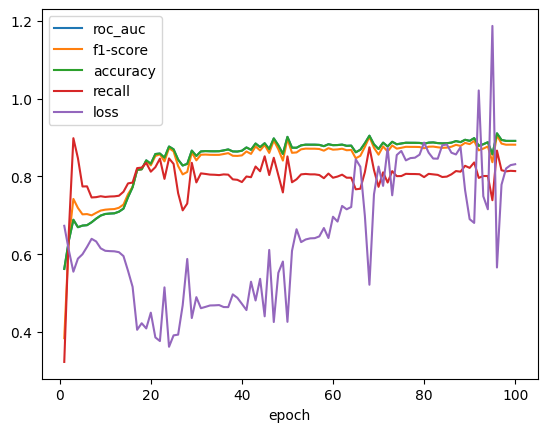

In [118]:
df = pd.DataFrame(trainer.results, index=range(1, len(trainer.results)+1))
df['epoch'] = df.index
df.loc[df['phase'] == 'test'].plot(x='epoch', y=['roc_auc', 'f1-score', 'accuracy', 'recall', 'loss'], kind='line')

In [119]:
max(df.loc[df['phase'] == 'test']['accuracy']), max(df.loc[df['phase'] == 'test']['f1-score'])

(0.9109833723246799, 0.9065914846097658)